In [0]:
#Importing all required libraries and modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from tqdm import tqdm_notebook, trange
from tqdm import tqdm
import sys
import time
from sklearn.metrics import accuracy_score, classification_report
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from pandas import read_csv
from google.colab import drive
from imblearn.over_sampling import SMOTE
import pickle


In [0]:
#Defining the neural network class and related functions
#Sigmoid function-> f(x)=1/1+e^-x
#ReLU Function-> Rectified Linear Unit Function-> f(x)=max(0,x)
#sigmoid_backward-> Derivative for backpropogation
#relu_backward -> "Derivative":) for backpropogation 
#forward_prop_this_layer -> Calculates Z and activation(z) where Z=w.x + b
#backprop_this_layer -> Back propogation step to update the weights on each epoch
#update -> function to update the weights based on the formula: θ=θ-(α*∂L/∂θ)
#                                                               θ-> Paramter to be updated
#                                                               α-> Learning Rate
#                                                               L-> Loss Function
#fit-> "Fits" the data to the model by trainning the neural net whilst updating the model weights and biases 
class NeuralNet():
  
  def __init__(self, architecture):
    self.architecture = architecture
    self.params = self._initialize_params(architecture)
  
  def _initialize_params(self, architecture):
    params = {}
    for id_, layer in enumerate(architecture):
      layer_id = id_ + 1

      input_dim = layer['input_dim']
      output_dim = layer['output_dim']

      params['W'+str(layer_id)] = np.random.randn(output_dim, input_dim)*0.1
      params['b'+str(layer_id)] = np.zeros((output_dim, 1))

    return params
  
  def sigmoid(self, Z):
    return 1/(1+np.exp(-Z))
  def relu(self, Z):
    return np.maximum(0, Z)

  def sigmoid_backward(self, dA, z_curr):
    sig = self.sigmoid(z_curr)
    return sig*(1-sig)*dA

  def relu_backward(self, dA, z_curr):
    dz = np.array(dA, copy=True)
    dz[z_curr<=0]=0
    return dz
  
  def _forward_prop_this_layer(self, A_prev, W_curr, b_curr, activation_function):
    z_curr = np.dot(W_curr, A_prev) + b_curr

    if activation_function is 'relu':
      activation = self.relu
    elif activation_function is 'sigmoid':
      activation = self.sigmoid
    else:
      raise Exception(f"{activation_function} is not supported, Only sigmoid, relu are supported")

    return activation(z_curr), z_curr

  def _forward(self, X):
    cache = {}
    A_current = X
    for layer_id_prev, layer in enumerate(self.architecture):
      current_layer_id = layer_id_prev+1

      A_previous = A_current
      activation = layer['activation']

      W_curr = self.params['W'+str(current_layer_id)]
      b_curr = self.params['b'+str(current_layer_id)]

      A_current, Z_curr = self._forward_prop_this_layer(A_previous, W_curr,
                                                  b_curr, activation)

      cache['A'+str(layer_id_prev)] = A_previous
      cache['Z'+str(current_layer_id)] = Z_curr
      
    return A_current, cache

  def _criterion(self, y, yhat):
    m = yhat.shape[1]
    cost = -1/m * (np.dot(y, np.log(yhat).T) + np.dot(1-y, np.log(1-yhat).T))
    return np.squeeze(cost)
  
  def _backprop_this_layer(self, da_curr, z_curr, W_curr, b_curr, A_prev, activation_function):
    if activation_function is 'sigmoid':
      activation_back = self.sigmoid_backward
    elif activation_function is 'relu':
      activation_back = self.relu_backward
    else:
      raise Exception('need sigmoid or relu')
    m = A_prev.shape[1]

    dz_curr = activation_back(da_curr, z_curr)
    dw_curr = np.dot(dz_curr, A_prev.T)/m
    db_curr = np.sum(dz_curr, axis=1, keepdims=True)/m
    da_prev = np.dot(W_curr.T, dz_curr)

    return da_prev, dw_curr, db_curr
  
  def _backward(self, ytrue, ypred, cache):
    grads = {}
    m = ytrue.shape[1]
    da_prev = np.divide(1-ytrue, 1-ypred) - np.divide(ytrue, ypred)
    
    for prev_layer_id, layer in reversed(list(enumerate(self.architecture))):
      layer_id = prev_layer_id + 1
      activation = layer['activation']

      da_curr = da_prev

      A_prev = cache['A'+str(prev_layer_id)]
      Z_curr = cache['Z'+str(layer_id)]

      W_curr = self.params['W'+str(layer_id)]
      b_curr = self.params['b'+str(layer_id)]

      da_prev, dw_curr, db_curr = self._backprop_this_layer(
          da_curr, Z_curr, W_curr, b_curr, A_prev, activation)

      grads["dw"+str(layer_id)] = dw_curr
      grads['db'+str(layer_id)] = db_curr

    return grads
  
  def update(self, grads, learning_rate):
    for layer_id, layer in enumerate(self.architecture, 1):
      self.params['W'+str(layer_id)] -= learning_rate * grads['dw'+str(layer_id)]
      self.params['b'+str(layer_id)] -= learning_rate * grads['db'+str(layer_id)]
  
  def fit(self, X, y, epochs, learning_rate, verbose=True, show_loss=True):
    X, y = X.T, y.reshape((y.shape[0],-1)).T
    loss_history, accuracy_history = [], []
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      yhat, cache = self._forward(X)
      loss = self._criterion(y, yhat)
      loss_history.append(loss)

      yacc = yhat.copy()
      yacc[yacc>0.5] = 1
      yacc[yacc<=0.5] = 0

      accuracy = np.sum(y[0]==yacc[0])/(yacc.shape[1])
      accuracy_history.append(accuracy)

      grads_values = self._backward(y, yhat, cache)

      self.update(grads_values, learning_rate)
      if(epoch % 1000 == 0):
              if(verbose):
                  print("Epoch: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(epoch, loss, accuracy))

        
    fig = plt.figure(figsize=(12,10))
    plt.plot(range(epochs), loss_history, 'r-')
    plt.plot(range(epochs), accuracy_history, 'b--')
    plt.legend(['Training_loss', 'Training_Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.show()

  def predict(self, X):
    yhat, _ = self._forward(X)
    yhat[yhat>0.6]=1
    yhat[yhat<=0.6]=0
    return np.squeeze(yhat)

In [0]:
#Function to load the dataset in Google Drive on to the Google Colaboatory Notebook Enivornment
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Using pandas read_csv to load the data onto a pandas Dataframe
df=read_csv('/content/drive/My Drive/ml data/cat3.csv')
cat1_data=read_csv('/content/drive/My Drive/ml data/cat1.csv')

In [ ]:
#Seeing few values of the data
#and then observing few statistics of the data
df.head()
df.describe()

In [0]:
#generating y and dropping unimportant features
y=cat1_data[["class"]]
y=y.values
print(len(cat1_data),len(y))
cat1_data=cat1_data.drop(['class'], axis = 1)
cat1_data=cat1_data.drop(['pred'],axis=1)
cat1_data=cat1_data.drop(['spectrometric_redshift'],axis=1)

33463 33463


In [0]:
#Creating a correlation matrix to observe correlations between the diferent paramters
correlation_matrix=cat1_data.corr()

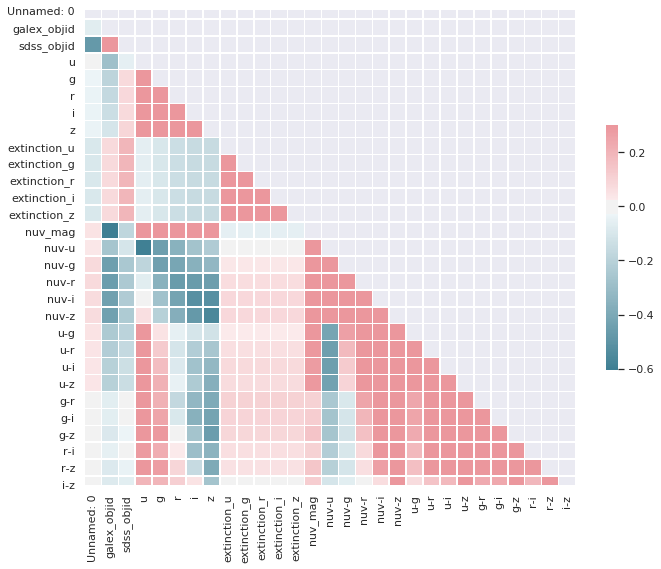

In [0]:
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
#Selecting features that are would most help in classification of the dataset into stars and quasars 
#NOT considering red shift else the model is redundant:/
X_pre=df[["i","z","extinction_u","extinction_g","nuv-u","nuv-g","nuv-r","u-i","u-z","g-r","r-i","r-z","nuv-z","u-g","u-r","nuv_mag"]]
Y_pre=df[["class"]]
X = X_pre.loc[:, X_pre.columns != 'class']
y = Y_pre.loc[:, Y_pre.columns == 'class']
print(X.shape)
in_dim=X.shape[1]
print(in_dim)

(4295, 16)
16


In [0]:
#Upsampling of data to take care of the data imbalance
os = SMOTE(random_state=0)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=0)
columns = X_train1.columns
os_data_X,os_data_y=os.fit_sample(X_train1, y_train1)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['class'])
# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['class']==0]))
print("Number of subscription",len(os_data_y[os_data_y['class']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['class']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['class']==1])/len(os_data_X))

length of oversampled data is  6890
Number of no subscription in oversampled data 3445
Number of subscription 3445
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
os_data_X.shape
os_data_y.shape

(6890, 1)

In [0]:
#Creating a train test split to create a validation set
X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, stratify=os_data_y, test_size=0.3, random_state=42)

In [0]:
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values

In [0]:
#Defining the neural net architecture and model hyperparaemeters
NN_ARCHITECTURE = [
    {"input_dim": in_dim, "output_dim": 16, "activation": "relu"}, # Input Layer
    {"input_dim": 16, "output_dim": 32, "activation": "relu"},# Hidden Layer -- 1 Second Hidden Layer
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},#{"input_dim": 16, "output_dim": 8, "activation": "relu"},# Third Hidden Layer,
    {"input_dim": 16, "output_dim": 1, "activation": "sigmoid"}# Output Layer
]

Epoch: 00000 - cost: 0.69334 - accuracy: 0.50010
Epoch: 01000 - cost: 0.68581 - accuracy: 0.70516
Epoch: 02000 - cost: 0.66643 - accuracy: 0.68920
Epoch: 03000 - cost: 0.59482 - accuracy: 0.69086
Epoch: 04000 - cost: 0.49183 - accuracy: 0.77462
Epoch: 05000 - cost: 0.43590 - accuracy: 0.80075
Epoch: 06000 - cost: 0.42311 - accuracy: 0.80220
Epoch: 07000 - cost: 0.40628 - accuracy: 0.81941
Epoch: 08000 - cost: 0.38699 - accuracy: 0.82832
Epoch: 09000 - cost: 0.37013 - accuracy: 0.84159
Epoch: 10000 - cost: 0.35434 - accuracy: 0.84698
Epoch: 11000 - cost: 0.34383 - accuracy: 0.84989
Epoch: 12000 - cost: 0.33329 - accuracy: 0.85445
Epoch: 13000 - cost: 0.32655 - accuracy: 0.85776
Epoch: 14000 - cost: 0.31729 - accuracy: 0.86087
Epoch: 15000 - cost: 0.30890 - accuracy: 0.86481
Epoch: 16000 - cost: 0.30368 - accuracy: 0.86647
Epoch: 17000 - cost: 0.29342 - accuracy: 0.87228
Epoch: 18000 - cost: 0.29215 - accuracy: 0.87290
Epoch: 19000 - cost: 0.28471 - accuracy: 0.87518
Epoch: 20000 - cost:

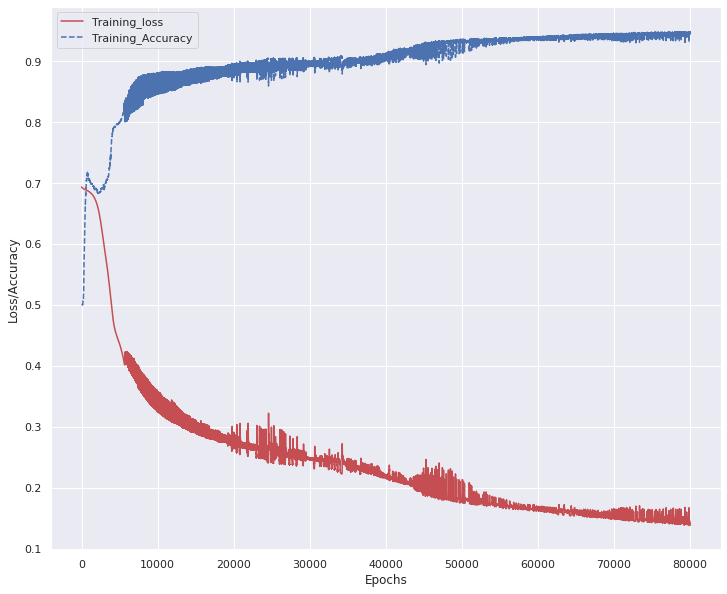

In [0]:
#Training the model 
net = NeuralNet(NN_ARCHITECTURE)
net.fit(X_train, y_train, epochs=80001, learning_rate=0.005, verbose=True, show_loss=True)

In [0]:
#Saving model parameters
with open('config.dictionary1', 'wb') as model_dictionary_file:
  pickle.dump(net, model_dictionary_file)

In [0]:
#Saving model parameters
with open('config.dictionary1', 'rb') as config_dictionary_file:
    net2 = pickle.load(config_dictionary_file)

In [0]:
net2

In [0]:
#Seeing test accuracy
predictions = net.predict(X_test.T)
accuracy_score(y_test, predictions)

0.9279148524431543

In [0]:
#Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1034
           1       0.94      0.91      0.93      1033

    accuracy                           0.93      2067
   macro avg       0.93      0.93      0.93      2067
weighted avg       0.93      0.93      0.93      2067



In [0]:
df1=read_csv('/content/drive/My Drive/ml data/cat4.csv')
#"fuv-nuv","fuv-u","fuv-g","fuv-r"
X_test1=df1[["i","z","extinction_u","extinction_g","nuv-u","nuv-g","nuv-r","u-i","u-z","g-r","r-i","r-z","nuv-z","u-g","u-r","nuv_mag"]]Y_test1=df1[["class"]]
Y_test2=Y_test1.values
Y_test1=df1[["class"]]
Y_test2=Y_test1.values

In [0]:
X_train2, X_tes2, y_train2, y_tes2 = train_test_split(X_test2, Y_test2, stratify=Y_test2, test_size=0.99, random_state=42)

In [0]:
print(X_tes2.shape)
predictions = net.predict(X_tes2.T)
accuracy_score(y_tes2, predictions)

(33129, 16)


0.8015937698089287

In [0]:
print(classification_report(y_tes2, predictions))

              precision    recall  f1-score   support

           0       0.65      0.75      0.69      9973
           1       0.88      0.83      0.85     23156

    accuracy                           0.80     33129
   macro avg       0.77      0.79      0.77     33129
weighted avg       0.81      0.80      0.81     33129

